# Deep Learning: Endoscopy segmentation.
[Dataset](https://www.kaggle.com/datasets/newslab/cholecseg8k?resource=download)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import cv2
import tensorflow as tf
import keras.backend as K
from sklearn.model_selection import train_test_split
from glob import glob
import segmentation_models as sm
from keras_vision_transformer import swin_layers
from keras_vision_transformer import transformer_layers
from keras_vision_transformer import utils

Segmentation Models: using `keras` framework.


In [2]:
tf.keras.backend.clear_session()
gpus = tf.config.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.list_logical_devices('GPU')
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)
print('GPU avalible: ' + str(len(tf.config.get_visible_devices('GPU')) > 0))

GPU avalible: True


In [3]:
SEED = 33
np.random.seed(SEED)
tf.random.set_seed(SEED)

## Data preparation.

In [4]:
imgs = glob(f'../*/*/*/frame_*_endo.png')
masks = glob(f'../*/*/*/frame_*_endo_watershed_mask.png')
_, imgs, _, masks = train_test_split(imgs, masks, test_size=0.2, random_state=43)
assert len(imgs) == len(masks)

print(f'Number of samples: {str(len(masks))}')

Number of samples: 1616


In [5]:
HEIGHT, WIDTH = 64, 128
N_CLASSES = 13
N = len(masks)
CLASS_WEIGHTS = np.array([2.45780159e-01, 2.24610010e-01, 2.24005501e-01, 1.87119512e-02,
 1.46965911e-01, 2.54698498e-02, 2.35562466e-02, 4.28713053e-03,
 3.93593665e-04, 1.38500705e-02, 6.78984614e-02, 1.01436955e-04,
 4.36967906e-03])


In [6]:
labels = [[11],[21],[13],[12],[31],[23],[24],[25],[32],[22],[33],[5]]
labels_encoding = {
    0: 'BG',
    1: 'Abdominal Wall',
    2: 'Liver',
    3: 'Gastrointestinal Tract',
    4: 'Fat',
    5: 'Grasper',
    6: 'Connective Tissue',
    7: 'Blood',
    8: 'Cystic Duct',
    9: 'L-hook Electrocautery',
    10: 'Gallbladder',
    11: 'Hepatic Vein',
    12: 'Liver Ligament',
}
def encode_masks(masks_arr, n_classes=N_CLASSES, size=N, H=HEIGHT, W=WIDTH, labels_arr=labels):
    y_encoded = np.zeros((size, H, W, 1), dtype=np.uint8)

    for i, label in enumerate(labels_arr):
        y_encoded[np.all(label == masks_arr, axis=-1)] = i + 1
    
    return tf.keras.utils.to_categorical(y_encoded, num_classes=n_classes)

In [7]:
def load_data(imgs_arr, masks_arr, H=HEIGHT, W=WIDTH):
    X, y = [], []

    for img, mask in zip(imgs_arr, masks_arr):
        img = cv2.imread(img)
        img = img[10:-10, 10:-10,:]
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (W, H))
        img = img / 255
        X.append(img)

        mask = cv2.imread(mask)
        mask = mask[10:-10, 10:-10,:]
        mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
        mask = cv2.resize(mask, (W, H), interpolation=cv2.INTER_NEAREST)
        mask = np.expand_dims(mask, axis=-1)

        y.append(mask)

    return np.array(X), encode_masks(np.array(y), H=H, W=W)

HEIGHT, WIDTH = 64, 128
X_unet, y_unet = load_data(imgs, masks, H=HEIGHT, W=WIDTH)
assert X_unet.shape[0:-1] == y_unet.shape[0:-1]

HEIGHT, WIDTH = 64, 64
X_swin_unet, y_swin_unet = load_data(imgs, masks, H=HEIGHT, W=WIDTH)
assert X_swin_unet.shape[0:-1] == y_swin_unet.shape[0:-1]

X_unet.shape, X_swin_unet.shape, y_unet.shape, y_swin_unet.shape

((1616, 64, 128, 3),
 (1616, 64, 64, 3),
 (1616, 64, 128, 13),
 (1616, 64, 64, 13))

## Swin-U-Net
### Swing transformer stack

In [8]:
def swin_transformer_stack(X, stack_num, embed_dim, num_patch, num_heads, window_size, num_mlp, shift_window=True, name=''):
    '''
    Stacked Swin Transformers that share the same token size.
    
    Alternated Window-MSA and Swin-MSA will be configured if `shift_window=True`, Window-MSA only otherwise.
    *Dropout is turned off.
    '''
    # Turn-off dropouts
    mlp_drop_rate = 0 # Droupout after each MLP layer
    attn_drop_rate = 0 # Dropout after Swin-Attention
    proj_drop_rate = 0 # Dropout at the end of each Swin-Attention block, i.e., after linear projections
    drop_path_rate = 0 # Drop-path within skip-connections
    
    qkv_bias = True # Convert embedded patches to query, key, and values with a learnable additive value
    qk_scale = None # None: Re-scale query based on embed dimensions per attention head # Float for user specified scaling factor
    
    if shift_window:
        shift_size = window_size // 2
    else:
        shift_size = 0
    
    for i in range(stack_num):
    
        if i % 2 == 0:
            shift_size_temp = 0
        else:
            shift_size_temp = shift_size

        X = swin_layers.SwinTransformerBlock(dim=embed_dim, 
                                             num_patch=num_patch, 
                                             num_heads=num_heads, 
                                             window_size=window_size, 
                                             shift_size=shift_size_temp, 
                                             num_mlp=num_mlp, 
                                             qkv_bias=qkv_bias, 
                                             qk_scale=qk_scale,
                                             mlp_drop=mlp_drop_rate, 
                                             attn_drop=attn_drop_rate, 
                                             proj_drop=proj_drop_rate, 
                                             drop_path_prob=drop_path_rate, 
                                             name='name{}'.format(i))(X)
    return X


def swin_unet_2d_base(input_tensor, filter_num_begin, depth, stack_num_down, stack_num_up, 
                      patch_size, num_heads, window_size, num_mlp, shift_window=True, name='swin_unet'):
    '''
    The base of Swin-UNET.
    
    The general structure:
    
    1. Input image --> a sequence of patches --> tokenize these patches
    2. Downsampling: swin-transformer --> patch merging (pooling)
    3. Upsampling: concatenate --> swin-transfprmer --> patch expanding (unpooling)
    4. Model head
    
    '''
    # Compute number be patches to be embeded
    input_size = input_tensor.shape.as_list()[1:]
    num_patch_x = input_size[0]//patch_size[0]
    num_patch_y = input_size[1]//patch_size[1]
    
    # Number of Embedded dimensions
    embed_dim = filter_num_begin
    
    depth_ = depth
    
    X_skip = []

    X = input_tensor
    
    # Patch extraction
    X = transformer_layers.patch_extract(patch_size)(X)

    # Embed patches to tokens
    X = transformer_layers.patch_embedding(num_patch_x*num_patch_y, embed_dim)(X)
    
    # The first Swin Transformer stack
    X = swin_transformer_stack(X, 
                               stack_num=stack_num_down, 
                               embed_dim=embed_dim, 
                               num_patch=(num_patch_x, num_patch_y), 
                               num_heads=num_heads[0], 
                               window_size=window_size[0], 
                               num_mlp=num_mlp, 
                               shift_window=shift_window, 
                               name='{}_swin_down0'.format(name))
    X_skip.append(X)
    
    # Downsampling blocks
    for i in range(depth_-1):
        
        # Patch merging
        X = transformer_layers.patch_merging((num_patch_x, num_patch_y), embed_dim=embed_dim, name='down{}'.format(i))(X)
        
        # update token shape info
        embed_dim = embed_dim*2
        num_patch_x = num_patch_x//2
        num_patch_y = num_patch_y//2
        
        # Swin Transformer stacks
        X = swin_transformer_stack(X, 
                                   stack_num=stack_num_down, 
                                   embed_dim=embed_dim, 
                                   num_patch=(num_patch_x, num_patch_y), 
                                   num_heads=num_heads[i+1], 
                                   window_size=window_size[i+1], 
                                   num_mlp=num_mlp, 
                                   shift_window=shift_window, 
                                   name='{}_swin_down{}'.format(name, i+1))
        
        # Store tensors for concat
        X_skip.append(X)
        
    # reverse indexing encoded tensors and hyperparams
    X_skip = X_skip[::-1]
    num_heads = num_heads[::-1]
    window_size = window_size[::-1]
    
    # upsampling begins at the deepest available tensor
    X = X_skip[0]
    
    # other tensors are preserved for concatenation
    X_decode = X_skip[1:]
    
    depth_decode = len(X_decode)
    
    for i in range(depth_decode):
        
        # Patch expanding
        X = transformer_layers.patch_expanding(num_patch=(num_patch_x, num_patch_y), 
                                               embed_dim=embed_dim, 
                                               upsample_rate=2, 
                                               return_vector=True)(X)
        

        # update token shape info
        embed_dim = embed_dim//2
        num_patch_x = num_patch_x*2
        num_patch_y = num_patch_y*2
        
        # Concatenation and linear projection
        X = tf.keras.layers.concatenate([X, X_decode[i]], axis=-1, name='{}_concat_{}'.format(name, i))
        X = tf.keras.layers.Dense(embed_dim, use_bias=False, name='{}_concat_linear_proj_{}'.format(name, i))(X)
        
        # Swin Transformer stacks
        X = swin_transformer_stack(X, 
                                   stack_num=stack_num_up, 
                                   embed_dim=embed_dim, 
                                   num_patch=(num_patch_x, num_patch_y), 
                                   num_heads=num_heads[i], 
                                   window_size=window_size[i], 
                                   num_mlp=num_mlp, 
                                   shift_window=shift_window, 
                                   name='{}_swin_up{}'.format(name, i))
        
    # The last expanding layer; it produces full-size feature maps based on the patch size
    # !!! <--- "patch_size[0]" is used; it assumes patch_size = (size, size)
    
    X = transformer_layers.patch_expanding(num_patch=(num_patch_x, num_patch_y), 
                                           embed_dim=embed_dim, 
                                           upsample_rate=patch_size[0], 
                                           return_vector=False)(X)
    
    return X

In [9]:
def dice_coeficient(y_true, y_pred):
    T = tf.keras.backend.flatten(y_true)
    P = tf.keras.backend.flatten(y_pred)

    intersection = tf.keras.backend.sum(T * P)
    dice = (2 * intersection) / (tf.keras.backend.sum(T + P))
    return dice

def dice_loss(y_true, y_pred):
    return 1 - dice_coeficient(y_true, y_pred)

def tversky(y_true, y_pred, smooth=1, alpha=0.8):
    T = tf.keras.backend.flatten(y_true)
    P = tf.keras.backend.flatten(y_pred)
    TP = tf.keras.backend.sum(T * P)
    FN = tf.keras.backend.sum(T * (1 - P))
    FP = tf.keras.backend.sum((1 - T) * P)
    return (TP + smooth) / (TP + alpha * FN + (1 - alpha) * FP + smooth)


def tversky_loss(y_true, y_pred):
    return 1 - tversky(y_true, y_pred)


def focal_tversky_loss(y_true, y_pred, gamma=0.75):
    tv = tversky(y_true, y_pred)
    return tf.keras.backend.pow((1 - tv), gamma)

def generalized_dice_coeff(y_true, y_pred, smooth=1e-9):
    Ncl = y_pred.shape[-1]
    w = np.zeros((Ncl,))
    w = K.sum(y_true, (0,1,2))
    w = 1 / (w ** 2 + smooth)

    y_pred = tf.nn.softmax(y_pred)

    # Compute gen dice coef:
    numerator = y_true * y_pred
    numerator = w * K.sum(numerator, (0,1,2))
    numerator = K.sum(numerator)

    denominator = y_true + y_pred
    denominator = w * K.sum(denominator, (0,1,2))
    denominator = K.sum(denominator)

    return 2. * (numerator + smooth) / (denominator + smooth)


def generalized_dice_loss(y_true, y_pred):
    return 1. - generalized_dice_coeff(y_true, y_pred)

In [10]:
filter_num_begin = 128     # number of channels in the first downsampling block; it is also the number of embedded dimensions
depth = 4                  # the depth of SwinUNET; depth=4 means three down/upsampling levels and a bottom level 
stack_num_down = 2         # number of Swin Transformers per downsampling level
stack_num_up = 2           # number of Swin Transformers per upsampling level
patch_size = (4, 4)        # Extract 4-by-4 patches from the input image. Height and width of the patch must be equal.
num_heads = [4, 8, 8, 8]   # number of attention heads per down/upsampling level
window_size = [4, 2, 2, 2] # the size of attention window per down/upsampling level
num_mlp = 512              # number of MLP nodes within the Transformer
shift_window=True          # Apply window shifting, i.e., Swin-MSA

HEIGHT, WIDTH = 64, 64
# Input section
IN = tf.keras.layers.Input((WIDTH, HEIGHT, 3))

# Base architecture
X = swin_unet_2d_base(IN, filter_num_begin, depth, stack_num_down, stack_num_up, 
                      patch_size, num_heads, window_size, num_mlp, 
                      shift_window=shift_window, name='swin_unet')



# Output section
n_labels = 13
OUT = tf.keras.layers.Conv2D(n_labels, kernel_size=1, use_bias=False, activation='softmax')(X)

# Model configuration
swin_transformer = tf.keras.models.Model(inputs=[IN,], outputs=[OUT,])
# Optimization
# <---- !!! gradient clipping is important
swin_transformer.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=7e-5, clipvalue=0.5, decay=1e-6), 
    loss=sm.losses.DiceLoss(),
    metrics=[tf.metrics.MeanIoU(num_classes=13), dice_coeficient]
)
swin_transformer.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 64, 64, 3)]  0           []                               
                                                                                                  
 patch_extract (patch_extract)  (None, 256, 48)      0           ['input_1[0][0]']                
                                                                                                  
 patch_embedding (patch_embeddi  (None, 256, 128)    39040       ['patch_extract[0][0]']          
 ng)                                                                                              
                                                                                                  
 swin_transformer_block (SwinTr  (None, 256, 128)    198724      ['patch_embedding[0][0]']    

In [11]:
swin_transformer.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=3e-4, clipvalue=0.5, decay=1e-6), 
    loss=tversky_loss,
    metrics=[tf.metrics.MeanIoU(num_classes=13), dice_coeficient]
)
swin_transformer.load_weights('../models/swin-unet_tversky.hdf5')

print('\n\t EVALUATION\n')
swin_transformer.evaluate(
    X_swin_unet, 
    y_swin_unet,
    batch_size=32
)


	 EVALUATION

51/51 [==============================] - 12s 55ms/step - loss: 0.0255 - mean_io_u_1: 0.9713 - dice_coeficient: 0.9745


[0.025543203577399254, 0.971255898475647, 0.9744909405708313]

## U-Net

In [12]:
def double_conv_block(x, n_filters):

   # Conv2D then ReLU activation
   x = tf.keras.layers.Conv2D(n_filters, 3, padding = "same", activation = "relu", kernel_initializer = "he_normal")(x)
   # Conv2D then ReLU activation
   x = tf.keras.layers.Conv2D(n_filters, 3, padding = "same", activation = "relu", kernel_initializer = "he_normal")(x)

   return x

def downsample_block(x, n_filters):
   f = double_conv_block(x, n_filters)
   p = tf.keras.layers.MaxPool2D(2)(f)
   p = tf.keras.layers.BatchNormalization()(p)
   p = tf.keras.layers.Dropout(0.2)(p)

   return f, p

def upsample_block(x, conv_features, n_filters):
   # upsample
   x = tf.keras.layers.Conv2DTranspose(n_filters, 3, 2, padding="same")(x)
   # concatenate
   x = tf.keras.layers.concatenate([x, conv_features])
   # dropout
   x = tf.keras.layers.BatchNormalization()(x)
   x = tf.keras.layers.Dropout(0.2)(x)
   # Conv2D twice with ReLU activation
   x = double_conv_block(x, n_filters)

   return x

def build_unet_model(n_filters=64, n_classes=2):
   # inputs
   HEIGHT, WIDTH = 64, 128
   inputs = tf.keras.layers.Input(shape=(HEIGHT,WIDTH,3))

   # encoder: contracting path - downsample
   # 1 - downsample
   f1, p1 = downsample_block(inputs, n_filters)
   # 2 - downsample
   f2, p2 = downsample_block(p1, n_filters*2)
   # 3 - downsample
   f3, p3 = downsample_block(p2, n_filters*4)
   # 4 - downsample
   f4, p4 = downsample_block(p3, n_filters*8)

   # 5 - bottleneck
   bottleneck = double_conv_block(p4, n_filters*16)

   # decoder: expanding path - upsample
   # 6 - upsample
   u6 = upsample_block(bottleneck, f4, n_filters*8)
   # 7 - upsample
   u7 = upsample_block(u6, f3, n_filters*4)
   # 8 - upsample
   u8 = upsample_block(u7, f2, n_filters*2)
   # 9 - upsample
   u9 = upsample_block(u8, f1, n_filters)

   # outputs
   
   activation = 'sigmoid' if n_classes == 2 else 'softmax'
   outputs = tf.keras.layers.Conv2D(n_classes, 1, padding="same", activation=activation)(u9)

   # unet model with Keras Functional API
   unet_model = tf.keras.Model(inputs, outputs, name="U-Net")

   return unet_model

In [13]:
unet_model = build_unet_model(n_filters=32, n_classes=13)
unet_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0e-4), 
    loss=dice_loss,
    metrics=[tf.metrics.MeanIoU(num_classes=13), dice_coeficient]
)
unet_model.load_weights('../models/u-net_DiceLoss_Class_Weights.hdf5')

print('\n\t EVALUATION\n')
unet_model.evaluate(
    X_unet, 
    y_unet,
    batch_size=32
)


	 EVALUATION

51/51 [==============================] - 18s 97ms/step - loss: 0.0283 - mean_io_u_2: 0.9588 - dice_coeficient: 0.9718


[0.028276167809963226, 0.9588114023208618, 0.971807599067688]

## Predictions

In [14]:
unet_pred = unet_model.predict(X_unet)
unet_pred = np.array(unet_pred)

51/51 [==============================] - 1s 20ms/step


In [15]:
swin_unet_pred = swin_transformer.predict(X_swin_unet)
swin_unet_pred = np.array(swin_unet_pred)

51/51 [==============================] - 5s 47ms/step


In [17]:
class_losses = {
    'Dice Coeficient U-Net' : [],
    'Dice Coeficient Swin U-Net' : [],
    'IoU U-Net' : [],
    'IoU Swin U-Net' : [],
}

for i in range(N_CLASSES):
    class_losses['Dice Coeficient U-Net'].append(1-sm.losses.DiceLoss(class_indexes=i)(y_unet, unet_pred).numpy())
    class_losses['IoU U-Net'].append(sm.metrics.IOUScore(class_indexes=i)(y_unet, unet_pred).numpy())
    class_losses['IoU Swin U-Net'].append(sm.metrics.IOUScore(class_indexes=i)(y_swin_unet, swin_unet_pred).numpy())
    class_losses['Dice Coeficient Swin U-Net'].append(1-sm.losses.DiceLoss(class_indexes=i)(y_swin_unet, swin_unet_pred).numpy())
    
pd.options.display.float_format = '{:.4f}'.format
pd.DataFrame(class_losses, index=labels_encoding.values())

,Dice Coeficient U-Net,Dice Coeficient Swin U-Net,IoU U-Net,IoU Swin U-Net
BG,0.9940,0.9945,0.9880,0.9890
Abdominal Wall,0.9869,0.9845,0.9741,0.9694
Liver,0.9745,0.9706,0.9503,0.9429
Gastrointestinal Tract,0.9495,0.9446,0.9039,0.8950
Fat,0.9756,0.9726,0.9524,0.9467
Grasper,0.9247,0.8976,0.8600,0.8142
Connective Tissue,0.9339,0.9322,0.8760,0.8730
Blood,0.4777,0.8299,0.3138,0.7092
Cystic Duct,0.0000,0.7811,0.0000,0.6408
L-hook Electrocautery,0.9534,0.9406,0.9110,0.8879


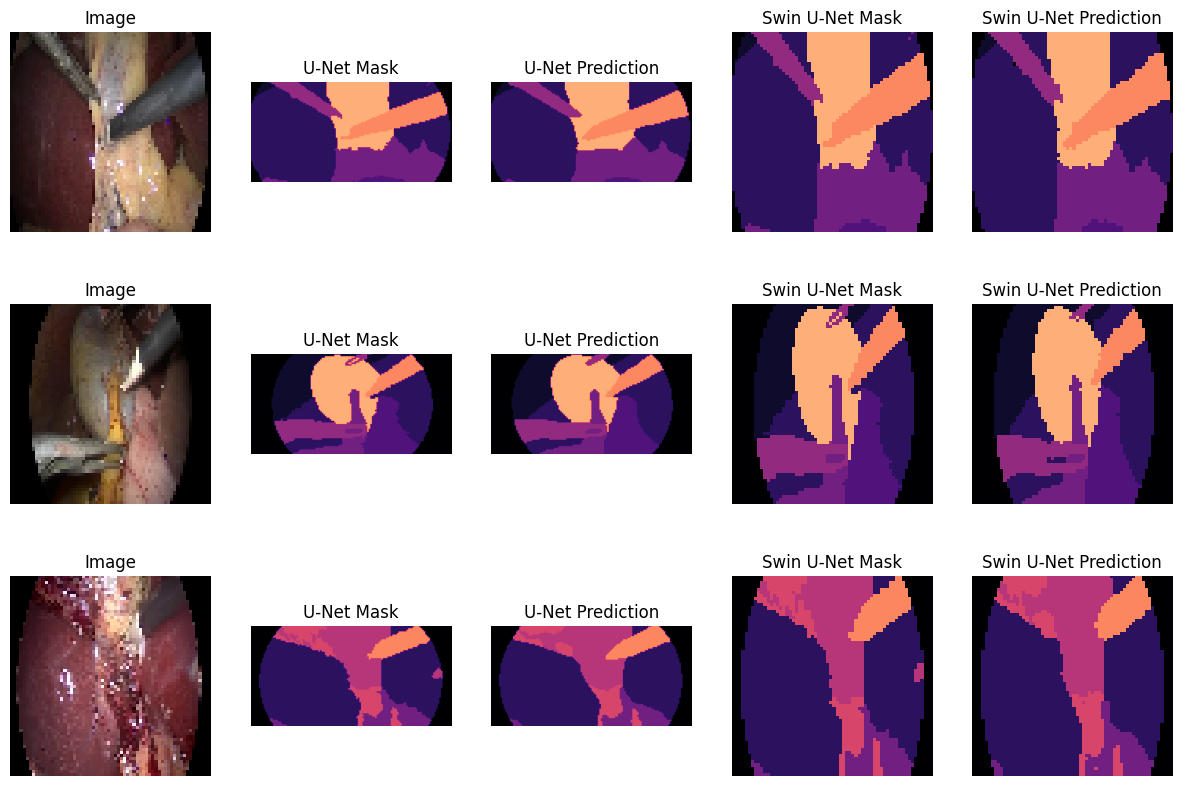

In [36]:
plt.figure(figsize=(15,10))
plt.tight_layout()
for i in range(3):    
    idx = random.randint(0, len(swin_unet_pred)-1)

    plt.subplot(3, 5, 1 + 5*i)
    plt.imshow(X_swin_unet[idx])
    plt.title('Image')
    plt.axis("off")

    plt.subplot(3, 5, 2 + 5*i)
    plt.imshow(tf.argmax(y_unet[idx], axis=-1), cmap='magma', norm=plt.Normalize(vmin=0, vmax=12))
    plt.title('U-Net Mask')
    plt.axis("off")

    plt.subplot(3, 5, 3 + 5*i)
    plt.imshow(tf.argmax(unet_pred[idx], axis=-1), cmap='magma', norm=plt.Normalize(vmin=0, vmax=12))
    plt.title('U-Net Prediction')
    plt.axis("off")

    plt.subplot(3, 5, 4 + 5*i)
    plt.imshow(tf.argmax(y_swin_unet[idx], axis=-1), cmap='magma', norm=plt.Normalize(vmin=0, vmax=12))
    plt.title('Swin U-Net Mask')
    plt.axis("off")

    plt.subplot(3, 5, 5 + 5*i)
    plt.imshow(tf.argmax(swin_unet_pred[idx], axis=-1), cmap='magma', norm=plt.Normalize(vmin=0, vmax=12))
    plt.title('Swin U-Net Prediction')
    plt.axis("off")

plt.show()

 --- 
 TFG - Alejandro García Mota